In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_27_24_DRIVE_to_STARE_PropAnalysis'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/storage/vbutoi/projects/ESE/ese/experiment/analysis/analyze_inf.py:171: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  inference_df = pd.concat([inference_df, log_image_df])


Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 9504 -> 9216 rows.
Finished loading inference stats.
Log amounts: root                                                                        log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_27_24_DRIVE_to_STARE_PropAnalysis  20240627_115938-T3IZ-cf35c265851deb7a65817e478aad9789    210
                                                                            20240627_115943-SKZJ-72ca09f1bdd77b3a212fce90af48e479    210
                                                                            20240627_115947-T4XZ-7a582c014603680e947e4547d1b38783    210
                                                                            20240627_115951-KZUW-96e85c2e2422520a5e4b2d3256264954    210
                                                                            20240627_115955-VQXN-dda62b10158ed9d64b565b6674fcbf54    210
                                                

In [4]:
def loss_func(loss_func_class):
    if loss_func_class == "None":
        return 'Combo'
    else:
        return loss_func_class.split('.')[-1]

inference_df.augment(loss_func)

In [5]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "loss_func",
    "gt_proportion",
    "soft_proportion",
    "hard_proportion",
    "pretrained_seed", 
    "pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

In [6]:
# Get number of examples we are evaluating on.
len(exp_df['data_id'].unique())

18

In [7]:
# We need to rename 'proportion' to 'proportion' for the sake of the experiment.
proportion_df = exp_df.rename(columns={
    "gt_proportion": "gt proportion",
    "hard_proportion": "hard proportion",
    "soft_proportion": "soft proportion",
})

In [8]:
# Make two new columns, one for the soft proportion error and one for the hard proportion error.
proportion_df['soft error'] = (proportion_df['soft proportion'] - proportion_df['gt proportion'])
proportion_df['hard error'] = (proportion_df['hard proportion'] - proportion_df['gt proportion'])
# Make the normalized metric that divides the error by the ground truth proportion.
proportion_df['soft relative error'] = proportion_df['soft error'] / proportion_df['gt proportion']
proportion_df['hard relative error'] = proportion_df['hard error'] / proportion_df['gt proportion']

In [9]:
proportion_df

,data_id,loss_func,gt proportion,soft proportion,hard proportion,pretrained_seed,pretrained_exp_root,split,soft error,hard error,soft relative error,hard relative error
0,im0139,Combo,0.133450,0.043003,0.018921,46,/storage/vbutoi/scratch/ESE/training/06_24_24_...,train,-0.090447,-0.114529,-0.677760,-0.858217
1,im0005,Combo,0.105708,0.088180,0.052063,46,/storage/vbutoi/scratch/ESE/training/06_24_24_...,train,-0.017529,-0.053645,-0.165820,-0.507484
2,im0003,Combo,0.066515,0.022494,0.004761,46,/storage/vbutoi/scratch/ESE/training/06_24_24_...,train,-0.044022,-0.061755,-0.661827,-0.928426
3,im0077,Combo,0.114421,0.064691,0.029968,46,/storage/vbutoi/scratch/ESE/training/06_24_24_...,train,-0.049730,-0.084452,-0.434622,-0.738087
4,im0044,Combo,0.101962,0.070455,0.031921,46,/storage/vbutoi/scratch/ESE/training/06_24_24_...,train,-0.031507,-0.070041,-0.309011,-0.686929
...,...,...,...,...,...,...,...,...,...,...,...,...
859,im0002,PixelCELoss,0.067682,0.047490,0.012451,41,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val,-0.020193,-0.055231,-0.298348,-0.816035
860,im0236,PixelCELoss,0.117881,0.064818,0.041626,41,/storage/vbutoi/scratch/ESE/training/06_24_24_...,cal,-0.053062,-0.076255,-0.450136,-0.646880
861,im0004,PixelCELoss,0.083948,0.038873,0.002625,41,/storage/vbutoi/scratch/ESE/training/06_24_24_...,cal,-0.045076,-0.081324,-0.536946,-0.968737
862,im0162,PixelCELoss,0.101341,0.042538,0.013550,41,/storage/vbutoi/scratch/ESE/training/06_24_24_...,cal,-0.058802,-0.087791,-0.580244,-0.866295


In [10]:
# Important for this experiment that we only consider the 'val' and 'cal' splits because we trained on the 'train' split.
proportion_df['split'].unique()

array(['train', 'val', 'cal'], dtype=object)

# Library Funcs

In [11]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(pretrained_exp_root):
    if "SVLS" in pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the proportion_type is hard_proportion_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['proportion_type'] == f'hard {value_name}'))]
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        if calibrator == "Uncalibrated":
            return "Uncalibrated " + proportion_type.split(" ")[0] + f" ({loss_func})"
        else:
            return calibrator + " soft" + f" ({loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [12]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "pretrained_seed", 
        "gt proportion", 
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["soft error", "hard error"],
    var_name="proportion_type",
    value_name="error"
)
# Process the proportion types.
melted_error_df = process_method_names(raw_melted_error_df, value_name="error")

In [13]:
melted_error_df

,calibrator,loss_func,data_id,pretrained_seed,gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
481,Uncalibrated,PixelCELoss,im0002,41,0.067682,0.041389,0.024353,val,soft error,-0.026294,0.026294,Uncalibrated soft (PixelCELoss)
643,SVLS,SoftDiceLoss,im0002,41,0.067682,0.014099,0.004150,val,soft error,-0.053583,0.053583,SVLS soft (SoftDiceLoss)
1093,Uncalibrated,PixelCELoss,im0002,46,0.067682,0.053713,0.045288,val,hard error,-0.022394,0.022394,Uncalibrated hard (PixelCELoss)
625,SVLS,Combo,im0002,43,0.067682,0.025351,0.002563,val,soft error,-0.042331,0.042331,SVLS soft (Combo)
1147,Uncalibrated,PixelCELoss,im0002,47,0.067682,0.010653,0.007263,val,hard error,-0.060419,0.060419,Uncalibrated hard (PixelCELoss)
...,...,...,...,...,...,...,...,...,...,...,...,...
317,SVLS,SoftDiceLoss,im0324,46,0.093156,0.003772,0.000366,train,soft error,-0.089384,0.089384,SVLS soft (SoftDiceLoss)
209,Uncalibrated,SoftDiceLoss,im0324,46,0.093156,0.002115,0.001038,train,soft error,-0.091040,0.091040,Uncalibrated soft (SoftDiceLoss)
533,Uncalibrated,SoftDiceLoss,im0324,45,0.093156,0.000343,0.000244,train,soft error,-0.092813,0.092813,Uncalibrated soft (SoftDiceLoss)
1613,Uncalibrated,Combo,im0324,45,0.093156,0.000489,0.000183,train,hard error,-0.092972,0.092972,Uncalibrated hard (Combo)


In [14]:
melted_error_df['proportion type'].unique()

array(['Uncalibrated soft (PixelCELoss)', 'SVLS soft (SoftDiceLoss)',
       'Uncalibrated hard (PixelCELoss)', 'SVLS soft (Combo)',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (PixelCELoss)',
       'Uncalibrated hard (Combo)', 'Uncalibrated soft (Combo)',
       'Uncalibrated hard (SoftDiceLoss)'], dtype=object)

In [15]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['proportion type'] = melted_error_df['proportion type'].astype('category')
melted_error_df['proportion type'] = melted_error_df['proportion type'].cat.reorder_categories([
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'SVLS soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (SoftDiceLoss)',
    'Uncalibrated hard (Combo)',
    'Uncalibrated soft (Combo)',
    'SVLS soft (Combo)',
])

# Custom palette dictionary
custom_palette = {
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'SVLS soft (PixelCELoss)': 'lightsteelblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (SoftDiceLoss)': 'limegreen',
    'Uncalibrated hard (Combo)': 'darkgoldenrod',
    'Uncalibrated soft (Combo)': 'darkorange',
    'SVLS soft (Combo)': 'sandybrown',
}

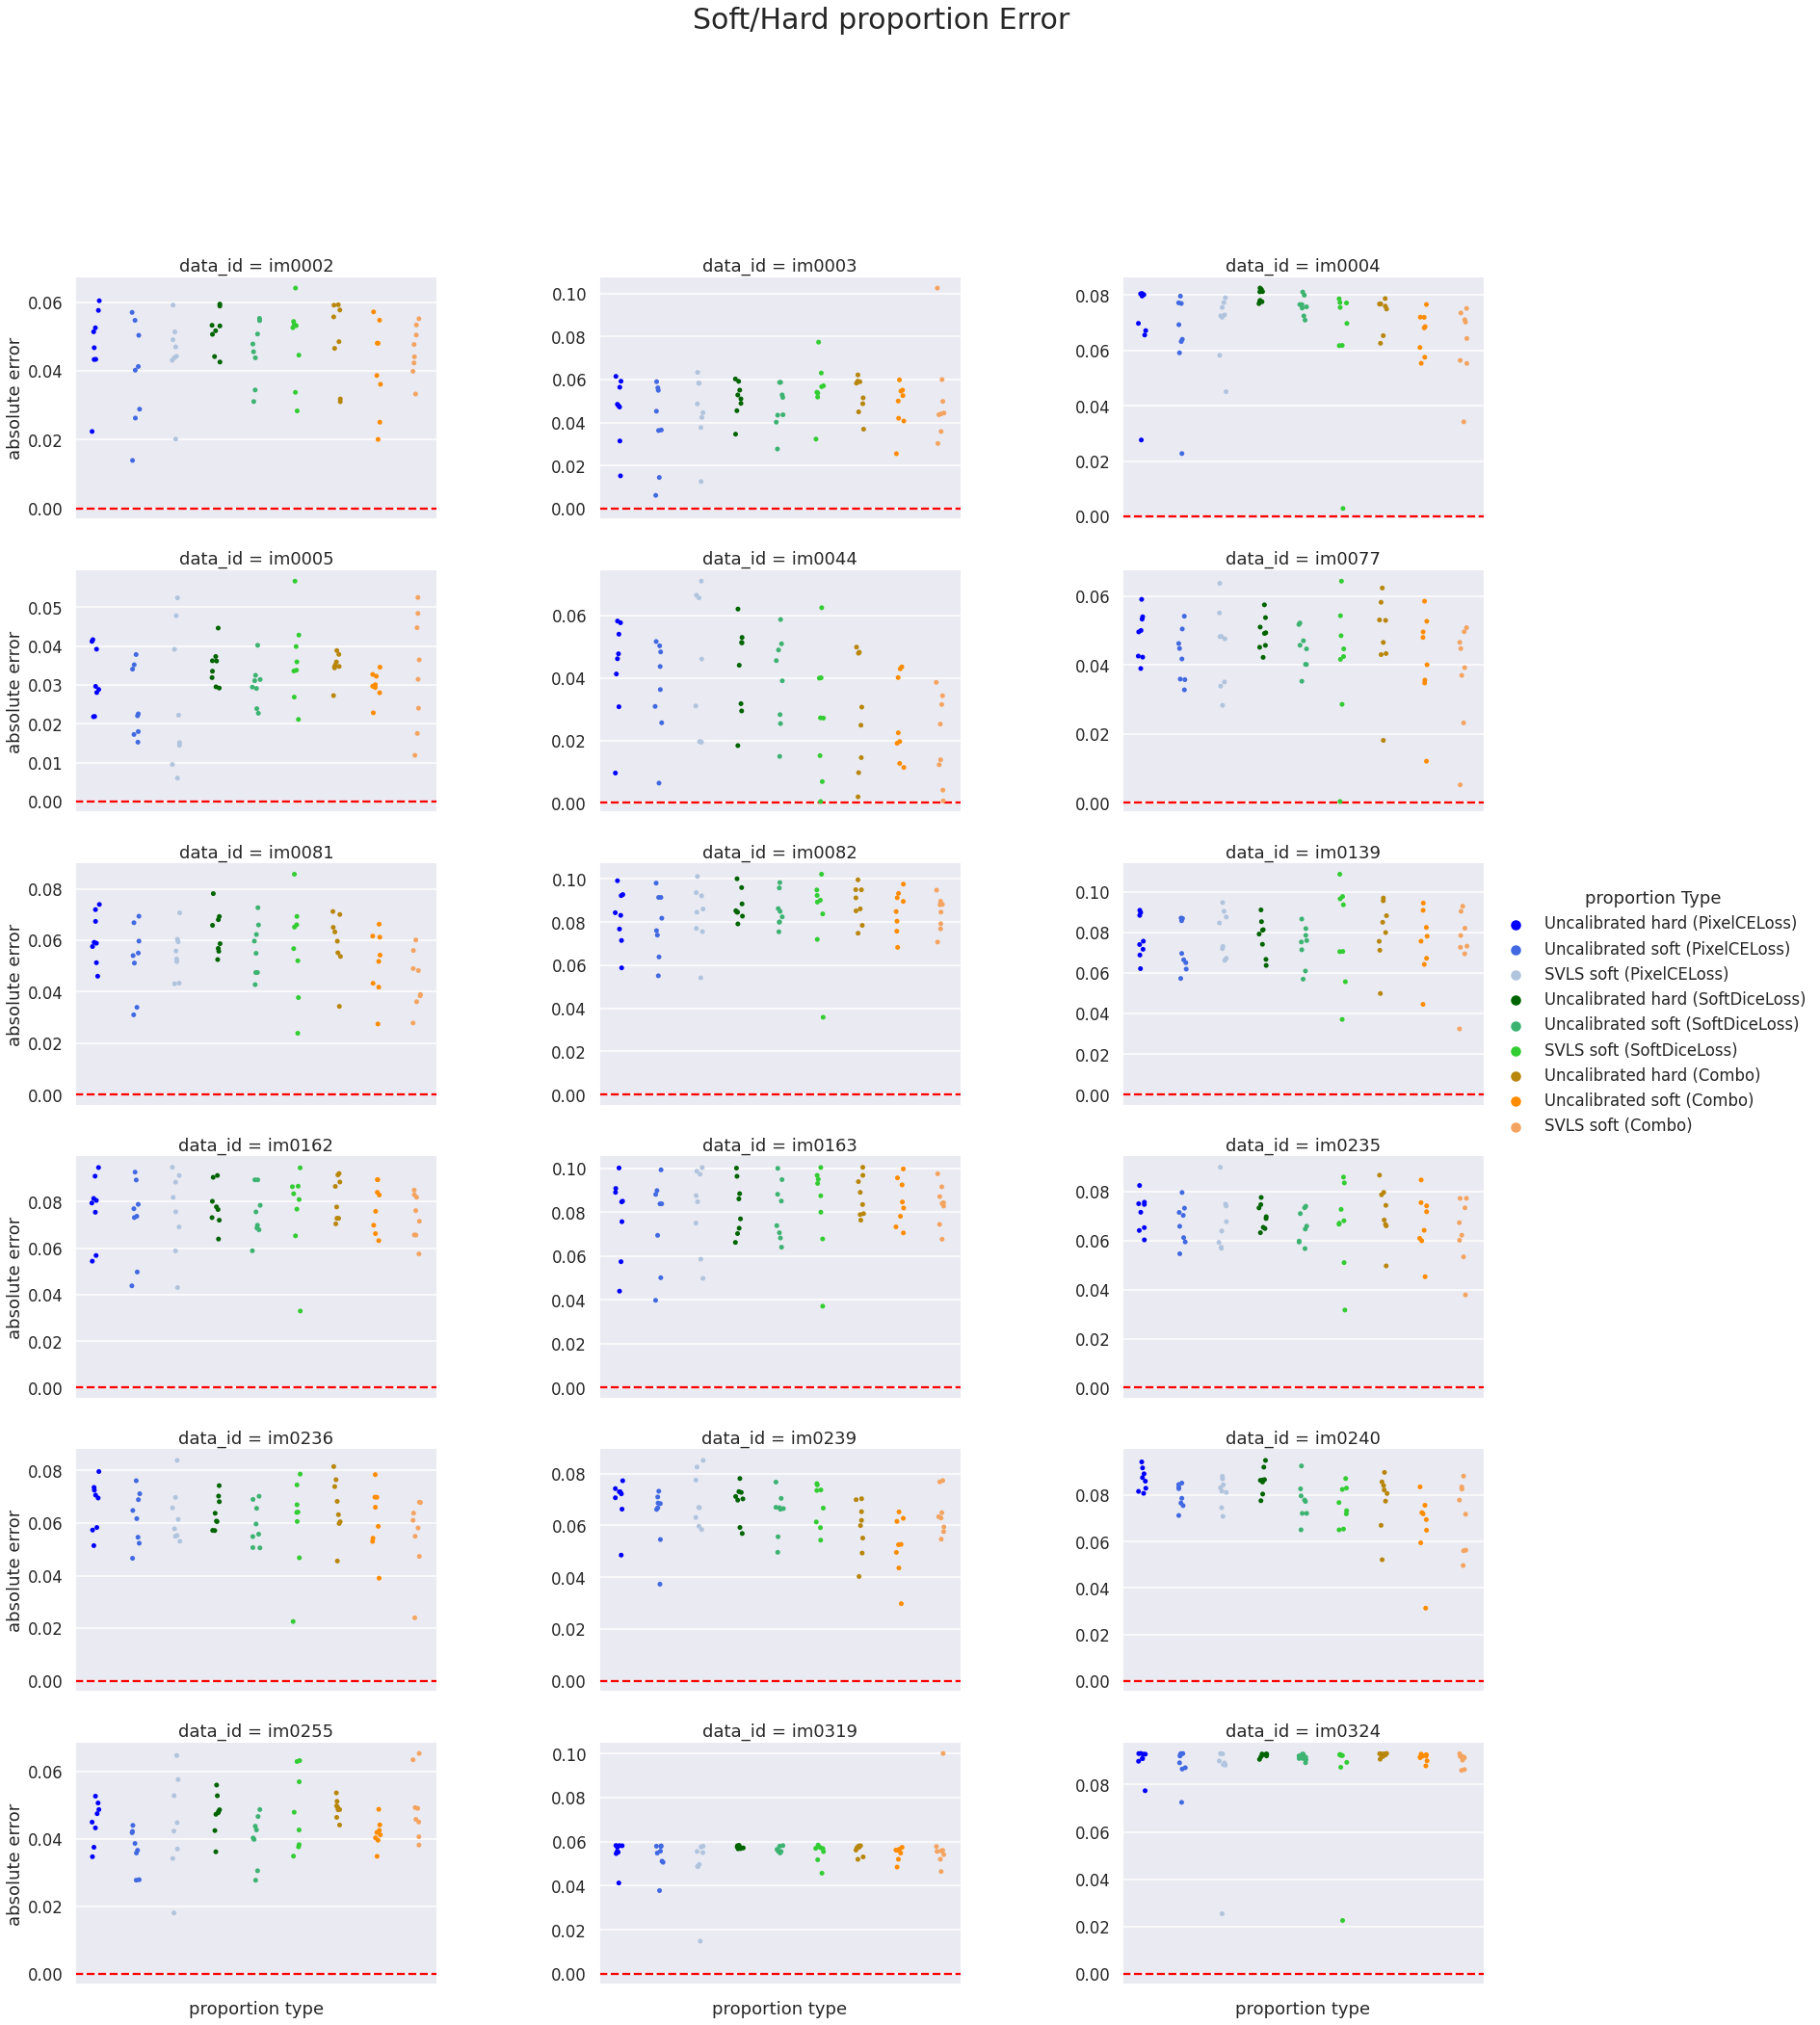

In [16]:
# Create the catplot
g = sns.catplot(
    data=melted_error_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute error",
    col="data_id",
    hue="proportion type",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [17]:
melted_error_df

,calibrator,loss_func,data_id,pretrained_seed,gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
481,Uncalibrated,PixelCELoss,im0002,41,0.067682,0.041389,0.024353,val,soft error,-0.026294,0.026294,Uncalibrated soft (PixelCELoss)
643,SVLS,SoftDiceLoss,im0002,41,0.067682,0.014099,0.004150,val,soft error,-0.053583,0.053583,SVLS soft (SoftDiceLoss)
1093,Uncalibrated,PixelCELoss,im0002,46,0.067682,0.053713,0.045288,val,hard error,-0.022394,0.022394,Uncalibrated hard (PixelCELoss)
625,SVLS,Combo,im0002,43,0.067682,0.025351,0.002563,val,soft error,-0.042331,0.042331,SVLS soft (Combo)
1147,Uncalibrated,PixelCELoss,im0002,47,0.067682,0.010653,0.007263,val,hard error,-0.060419,0.060419,Uncalibrated hard (PixelCELoss)
...,...,...,...,...,...,...,...,...,...,...,...,...
317,SVLS,SoftDiceLoss,im0324,46,0.093156,0.003772,0.000366,train,soft error,-0.089384,0.089384,SVLS soft (SoftDiceLoss)
209,Uncalibrated,SoftDiceLoss,im0324,46,0.093156,0.002115,0.001038,train,soft error,-0.091040,0.091040,Uncalibrated soft (SoftDiceLoss)
533,Uncalibrated,SoftDiceLoss,im0324,45,0.093156,0.000343,0.000244,train,soft error,-0.092813,0.092813,Uncalibrated soft (SoftDiceLoss)
1613,Uncalibrated,Combo,im0324,45,0.093156,0.000489,0.000183,train,hard error,-0.092972,0.092972,Uncalibrated hard (Combo)


In [18]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
error_per_seed = melted_error_df.groupby(["pretrained_seed", "proportion type"]).agg(
    abs_error=("absolute error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_seed.rename(columns={"abs_error": "absolute error"})

In [19]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_error_table = error_per_seed.pivot_table(
    values="absolute error",
    index="proportion type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_error_table['mean'] = method_error_table.mean(axis=1)
method_error_table['stdv'] = method_error_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_error_table = method_error_table[['mean', 'stdv']]

In [20]:
method_error_table.sort_values(by='mean')

pretrained_seed,mean,stdv
proportion type,,
Uncalibrated soft (PixelCELoss),0.058258,0.007363
Uncalibrated soft (Combo),0.058898,0.006619
SVLS soft (Combo),0.059103,0.003560
SVLS soft (SoftDiceLoss),0.061255,0.011666
SVLS soft (PixelCELoss),0.061311,0.009057
Uncalibrated soft (SoftDiceLoss),0.061585,0.005632
Uncalibrated hard (PixelCELoss),0.063639,0.006043
Uncalibrated hard (Combo),0.064080,0.006186
Uncalibrated hard (SoftDiceLoss),0.065792,0.004355


## Second, let's look at relative error.

In [21]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "pretrained_seed", 
        "gt proportion", 
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["soft relative error", "hard relative error"],
    var_name="proportion_type",
    value_name="relative error"
)
# Process the proportion types.
melted_relative_df = process_method_names(raw_melted_relative_df, value_name="relative error")

In [22]:
melted_relative_df['proportion type'].unique()

array(['Uncalibrated soft (PixelCELoss)', 'SVLS soft (SoftDiceLoss)',
       'Uncalibrated hard (PixelCELoss)', 'SVLS soft (Combo)',
       'Uncalibrated soft (SoftDiceLoss)', 'SVLS soft (PixelCELoss)',
       'Uncalibrated hard (Combo)', 'Uncalibrated soft (Combo)',
       'Uncalibrated hard (SoftDiceLoss)'], dtype=object)

In [23]:
# Finally, we want to change the order that the methods appear in.
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].astype('category')
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].cat.reorder_categories([
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'SVLS soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (SoftDiceLoss)',
    'Uncalibrated hard (Combo)',
    'Uncalibrated soft (Combo)',
    'SVLS soft (Combo)',
])

# Custom palette dictionary
custom_palette = {
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'SVLS soft (PixelCELoss)': 'lightsteelblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (SoftDiceLoss)': 'limegreen',
    'Uncalibrated hard (Combo)': 'darkgoldenrod',
    'Uncalibrated soft (Combo)': 'darkorange',
    'SVLS soft (Combo)': 'sandybrown',
}

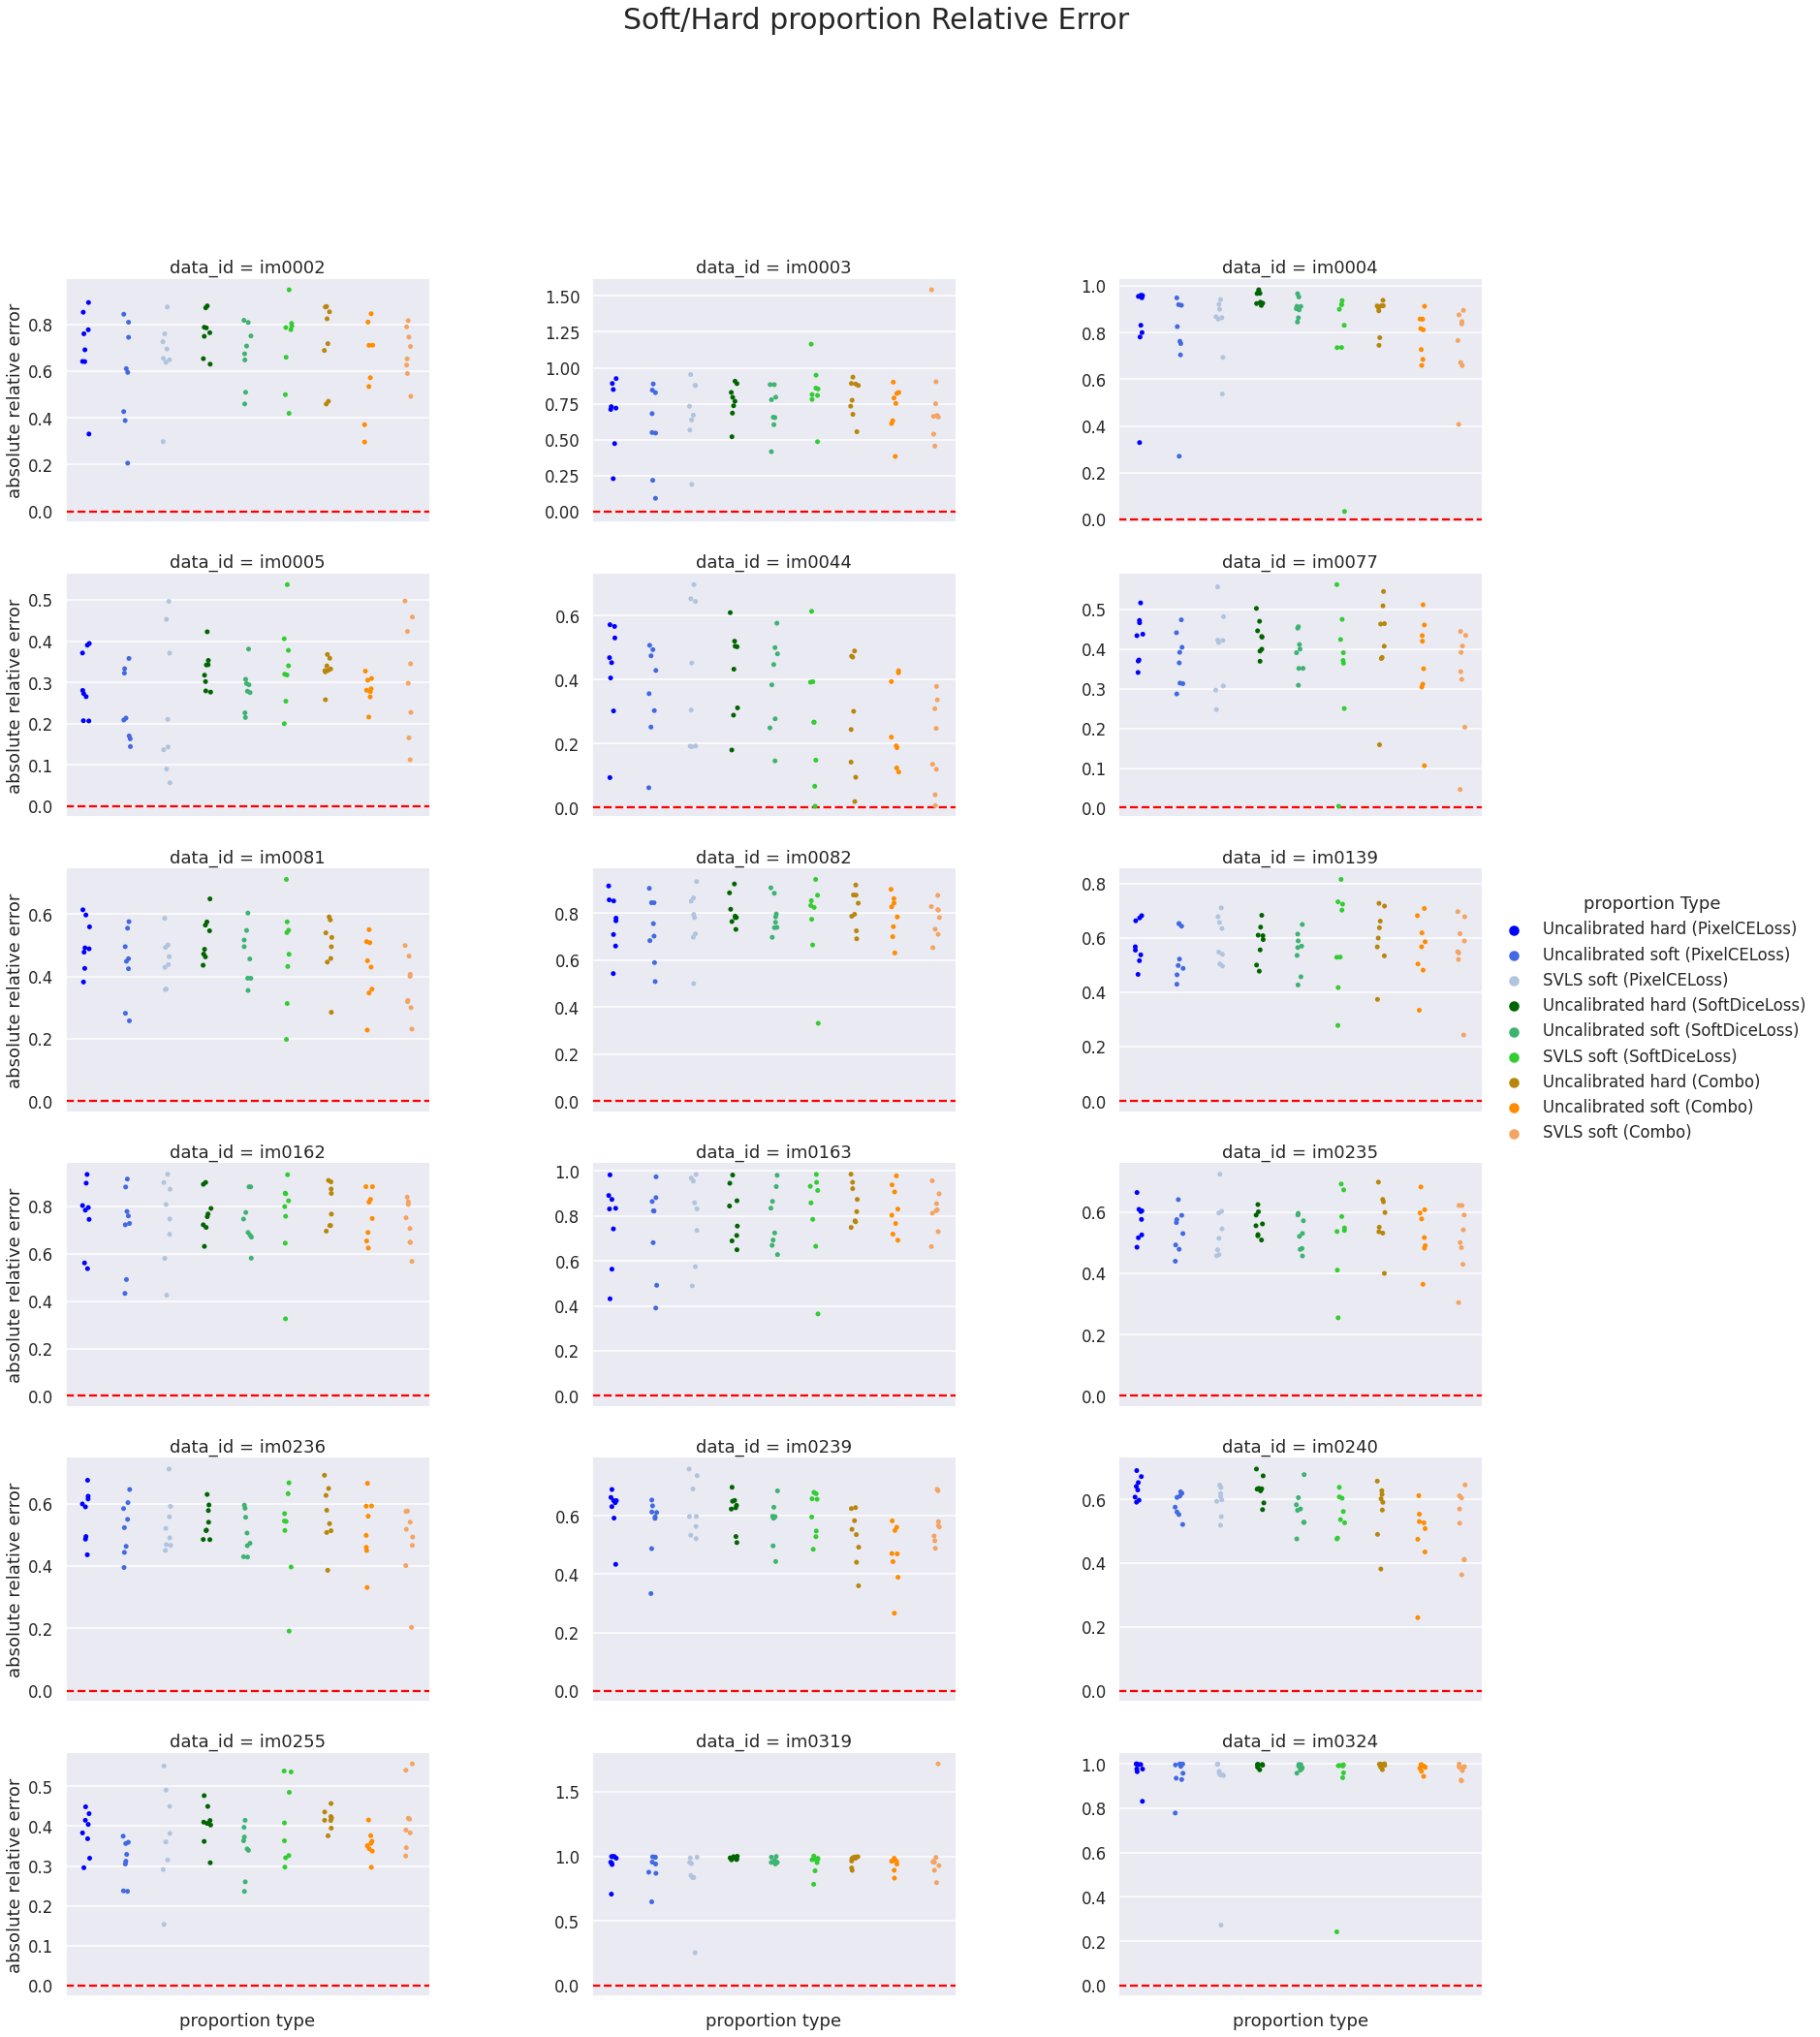

In [24]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute relative error",
    col="data_id",
    hue="proportion type",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard proportion Relative Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [25]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_seed = melted_relative_df.groupby(["pretrained_seed", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_seed = relative_per_seed.rename(columns={"abs_relative_error": "absolute relative error"})

In [26]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table = relative_per_seed.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table['mean'] = method_relative_table.mean(axis=1)
method_relative_table['stdv'] = method_relative_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table = method_relative_table[['mean', 'stdv']]

In [27]:
method_relative_table.sort_values(by='mean')

pretrained_seed,mean,stdv
proportion type,,
Uncalibrated soft (PixelCELoss),0.580185,0.080221
Uncalibrated soft (Combo),0.592528,0.066470
SVLS soft (Combo),0.598296,0.036690
SVLS soft (PixelCELoss),0.609654,0.097958
SVLS soft (SoftDiceLoss),0.615908,0.111345
Uncalibrated soft (SoftDiceLoss),0.619407,0.055868
Uncalibrated hard (PixelCELoss),0.634243,0.065055
Uncalibrated hard (Combo),0.643346,0.061048
Uncalibrated hard (SoftDiceLoss),0.660273,0.042494


# Finally, we want to look at the Dice score and Image ECE of all three methods as we are arguing that Image ECE is what we should care about.

In [28]:
inference_df

,pred_hash,image_metric,metric_score,batch_idx,split,data_cfg_opt,label_idx,gt_proportion,data_id,gt_volume,...,pred_label,pretrained_exp_root,pretrained_select_metric,loss_func_class,batch_reduction,from_logits,_pretrained_class,joint_data_slice_id,method_name,loss_func
0,-8394326610600517541,Dice,0.179907,0,train,split:train,-1,0.133450,im0139,1402,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,None,None,None,None,im0139_None,UNet (seed=46),Combo
1,-8394326610600517541,HD95,27.343096,0,train,split:train,-1,0.133450,im0139,1402,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,None,None,None,None,im0139_None,UNet (seed=46),Combo
2,-8394326610600517541,BoundaryIOU,0.098845,0,train,split:train,-1,0.133450,im0139,1402,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,None,None,None,None,im0139_None,UNet (seed=46),Combo
3,-8394326610600517541,SoftVolumeError,-697.440369,0,train,split:train,-1,0.133450,im0139,1402,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,None,None,None,None,im0139_None,UNet (seed=46),Combo
4,-8394326610600517541,HardVolumeError,-1092.000000,0,train,split:train,-1,0.133450,im0139,1402,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,None,None,None,None,im0139_None,UNet (seed=46),Combo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,-4426254950274265181,Dice Loss,0.717724,0,val,split:val,-1,0.067682,im0002,710,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,ese.experiment.losses.PixelCELoss,mean,1.0,None,im0002_None,UNet (seed=41),PixelCELoss
10076,6280628061247872411,Dice Loss,0.517274,0,cal,split:cal,-1,0.117881,im0236,1431,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,ese.experiment.losses.PixelCELoss,mean,1.0,None,im0236_None,UNet (seed=41),PixelCELoss
10077,-5022752492738003719,Dice Loss,0.978402,0,cal,split:cal,-1,0.083948,im0004,883,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,ese.experiment.losses.PixelCELoss,mean,1.0,None,im0004_None,UNet (seed=41),PixelCELoss
10078,-8258810701671685072,Dice Loss,0.709924,0,cal,split:cal,-1,0.101341,im0162,957,...,0,/storage/vbutoi/scratch/ESE/training/06_24_24_...,val-dice_score,ese.experiment.losses.PixelCELoss,mean,1.0,None,im0162_None,UNet (seed=41),PixelCELoss


In [29]:
# Get the relevant columns for looking at the Dice score and Image ECE
metric_cols = [
    "data_id",
    "loss_func",
    "pretrained_seed",
    "pretrained_exp_root",
    "split",
    "image_metric",
    "metric_score"
]
# Take these columns of the inference_df, drop other columns and delete duplicate rows.
metric_df = inference_df[metric_cols].drop_duplicates().reset_index(drop=True)
metric_df.augment(calibrator)
# Drop the 'pretrained_exp_root column
metric_df = metric_df.drop(columns=["pretrained_exp_root"])

In [30]:
def train_method(calibrator, loss_func):
    return calibrator + f" ({loss_func})"

metric_df.augment(train_method)

In [31]:
metric_df

,data_id,loss_func,pretrained_seed,split,image_metric,metric_score,calibrator,train_method
0,im0139,Combo,46,train,Dice,0.179907,SVLS,SVLS (Combo)
1,im0139,Combo,46,train,HD95,27.343096,SVLS,SVLS (Combo)
2,im0139,Combo,46,train,BoundaryIOU,0.098845,SVLS,SVLS (Combo)
3,im0139,Combo,46,train,SoftVolumeError,-697.440369,SVLS,SVLS (Combo)
4,im0139,Combo,46,train,HardVolumeError,-1092.000000,SVLS,SVLS (Combo)
...,...,...,...,...,...,...,...,...
10075,im0002,PixelCELoss,41,val,Dice Loss,0.717724,SVLS,SVLS (PixelCELoss)
10076,im0236,PixelCELoss,41,cal,Dice Loss,0.517274,SVLS,SVLS (PixelCELoss)
10077,im0004,PixelCELoss,41,cal,Dice Loss,0.978402,SVLS,SVLS (PixelCELoss)
10078,im0162,PixelCELoss,41,cal,Dice Loss,0.709924,SVLS,SVLS (PixelCELoss)


In [32]:
# Groupby the pretrained_seed and image_metrics, and calibrator, and take the mean of the metric_score.
metric_per_seed = metric_df.groupby(["pretrained_seed", "loss_func", "image_metric", "train_method"]).agg(
    metric_score=("metric_score", "mean"),
).reset_index()
# Finally, we want to change the order that the methods appear in.
metric_per_seed['train_method'] = metric_per_seed['train_method'].astype('category')
metric_per_seed['train_method'] = metric_per_seed['train_method'].cat.reorder_categories([
    'Uncalibrated (PixelCELoss)',
    'SVLS (PixelCELoss)',
    'Uncalibrated (SoftDiceLoss)',
    'SVLS (SoftDiceLoss)',
    'Uncalibrated (Combo)',
    'SVLS (Combo)',
])

In [33]:
result = metric_per_seed.groupby(['train_method', 'image_metric']).agg(
    mean_metric_score=('metric_score', 'mean'),
    std_metric_score=('metric_score', 'std')
).reset_index()

# Pivot the table to have one row for each train_method
result = result.pivot(
    index='train_method', 
    columns='image_metric', 
    values=[
        'mean_metric_score', 
        'std_metric_score'
    ]
)

# Flatten the column multi-index
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result = result.reset_index()

In [34]:
result

,train_method,mean_metric_score_BoundaryIOU,mean_metric_score_Dice,mean_metric_score_Dice Loss,mean_metric_score_HD95,mean_metric_score_HardVolumeError,mean_metric_score_Image_CW-ECE,mean_metric_score_Image_ECE,mean_metric_score_Image_ECW-ECE,mean_metric_score_Image_Edge-ECE,...,std_metric_score_Dice Loss,std_metric_score_HD95,std_metric_score_HardVolumeError,std_metric_score_Image_CW-ECE,std_metric_score_Image_ECE,std_metric_score_Image_ECW-ECE,std_metric_score_Image_Edge-ECE,std_metric_score_Image_Uniform-CW-ECE,std_metric_score_Image_Uniform-ECW-ECE,std_metric_score_SoftVolumeError
0,Uncalibrated (PixelCELoss),0.353300,0.485687,0.514313,9.361802,-477.368056,0.036009,0.036009,0.153012,0.159224,...,0.078159,2.999508,105.845279,0.007144,0.007144,0.028055,0.028445,0.007144,0.028055,128.971889
1,SVLS (PixelCELoss),0.150835,0.243559,0.756441,25.762056,-816.687500,0.037743,0.037743,0.170668,0.176949,...,0.040330,6.629456,53.182698,0.005677,0.005677,0.024390,0.024551,0.005677,0.024390,166.181700
2,Uncalibrated (SoftDiceLoss),0.352262,0.482391,0.517609,10.465401,-512.638889,0.037330,0.037330,0.160342,0.166856,...,0.062318,3.551778,76.280590,0.005939,0.005939,0.022789,0.022840,0.005939,0.022789,98.654513
3,SVLS (SoftDiceLoss),0.158523,0.251881,0.748119,26.417466,-802.381944,0.041192,0.041192,0.170664,0.176638,...,0.078462,7.068659,123.236110,0.007442,0.007442,0.035853,0.037614,0.007442,0.035853,391.440530
4,Uncalibrated (Combo),0.335443,0.464285,0.535715,10.789113,-478.645833,0.038236,0.038236,0.160152,0.166551,...,0.057571,3.063908,108.315440,0.005582,0.005582,0.020034,0.020263,0.005582,0.020034,117.993354
5,SVLS (Combo),0.161314,0.257785,0.742215,25.143151,-763.680556,0.039784,0.039784,0.160295,0.166073,...,0.064297,4.374731,183.081149,0.013885,0.013885,0.021781,0.023995,0.013885,0.021781,475.267622


In [35]:
# Get all the of the columns that are 'calibrator' and have 'Dice_Loss' in them
dice_cols = [col for col in result.columns if 'Dice Loss' in col or 'train_method' in col]
dice_result = result[dice_cols]

In [36]:
dice_result.sort_values(by='mean_metric_score_Dice Loss')

,train_method,mean_metric_score_Dice Loss,std_metric_score_Dice Loss
0,Uncalibrated (PixelCELoss),0.514313,0.078159
2,Uncalibrated (SoftDiceLoss),0.517609,0.062318
4,Uncalibrated (Combo),0.535715,0.057571
5,SVLS (Combo),0.742215,0.064297
3,SVLS (SoftDiceLoss),0.748119,0.078462
1,SVLS (PixelCELoss),0.756441,0.040330


In [37]:
# Get all the of the columns that are 'calibrator' and have 'Image_ECE' in them
image_ece_cols = [col for col in result.columns if 'Image_ECE' in col or 'train_method' in col]
ece_result = result[image_ece_cols]

In [38]:
ece_result.sort_values(by='mean_metric_score_Image_ECE')

,train_method,mean_metric_score_Image_ECE,std_metric_score_Image_ECE
0,Uncalibrated (PixelCELoss),0.036009,0.007144
2,Uncalibrated (SoftDiceLoss),0.037330,0.005939
1,SVLS (PixelCELoss),0.037743,0.005677
4,Uncalibrated (Combo),0.038236,0.005582
5,SVLS (Combo),0.039784,0.013885
3,SVLS (SoftDiceLoss),0.041192,0.007442
